In [1]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet

import get_binarized_map_of_selected_loci_2 as diff

In [49]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_2' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_2.py'>

In [41]:
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'
data_dir = '/home/braunger/masterthesis/data/'

# 1. Number of intermingling regions per chromosome pair

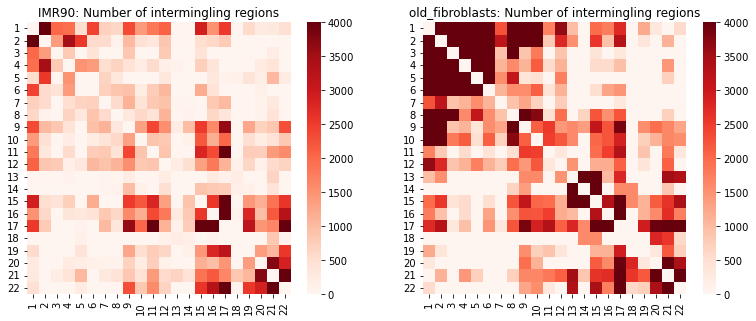

In [52]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
diff.plot_intermingling_regions(chr_list, hic_dir, "IMR90", 'intermingling_regions', 15, axs[0])
diff.plot_intermingling_regions(chr_list, hic_dir, "old_fibroblasts", 'intermingling_regions', 30, axs[1])
plt.savefig(fig_dir + 'intermingling_regions.png')
plt.show()

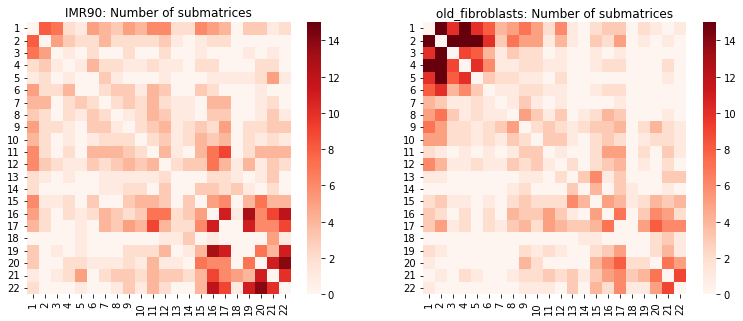

In [53]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
diff.plot_intermingling_regions(chr_list, hic_dir, "IMR90", 'LAS', 15, axs[0])
diff.plot_intermingling_regions(chr_list, hic_dir, "old_fibroblasts", 'LAS', 30, axs[1])
plt.savefig(fig_dir + 'submatrices.png')
plt.show()

In [55]:
chr_list = [1, 2, 3]
young_statistics = diff.LAS_statistics(chr_list, hic_dir, 'IMR90', 15)
old_statistics = diff.LAS_statistics(chr_list, hic_dir, 'old_fibroblasts', 30)

print('For young fibroblasts there are ', int(young_statistics['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_statistics['LAS'].sum()), ' submatrices.')
print('For old fibroblasts there are ', int(old_statistics['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_statistics['LAS'].sum()), ' submatrices.')

For young fibroblasts there are  7702  intermingling regions  and  20  submatrices.
For old fibroblasts there are  57646  intermingling regions  and  51  submatrices.


# 2. Overlap of selected TFs targets

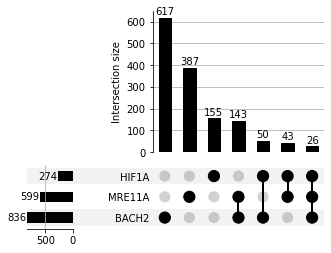

In [8]:
# load TF targets
tf_targets = pd.read_csv(save_dir + 'TF_targets/' + 'TF_targets_anno.csv', sep = ',')

# load TFs that were analysed in more details
selected_TFs = ['BACH2','HIF1A','MRE11A']

# create dict and plot intersections
intersections_loci = from_contents(dict([(TF, set(tf_targets.loc[tf_targets['TF'] == TF, 'locus'])) 
                                    for TF in selected_TFs]))
upset = UpSet(intersections_loci, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 10).plot()
plt.savefig(fig_dir + 'target_loci_overlap_neg-control.png')

In [20]:
BACH2_targets = set(tf_targets.loc[tf_targets['TF'] == 'BACH2', 'locus'])
HIF1A_targets = set(tf_targets.loc[tf_targets['TF'] == 'HIF1A', 'locus'])
MRE11A_targets = set(tf_targets.loc[tf_targets['TF'] == 'MRE11A', 'locus'])

BACH2_specific = BACH2_targets.difference(set.union(HIF1A_targets, MRE11A_targets))
HIF1A_specific = HIF1A_targets.difference(set.union(BACH2_targets, MRE11A_targets))
MRE11A_specific = MRE11A_targets.difference(set.union(BACH2_targets, HIF1A_targets))

# 3. Binarized maps

## a) BACH2

In [9]:
young_BACH2 = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/BACH2_subset.csv', index_col = 0)
old_BACH2 = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/BACH2_subset.csv', index_col = 0)

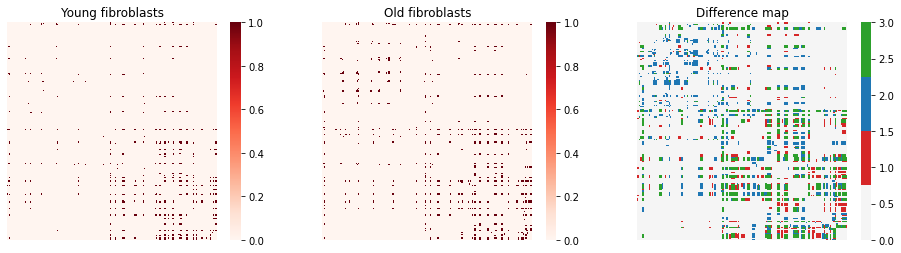

In [13]:
%matplotlib inline
diff.plot_binarized_maps(young_BACH2,old_BACH2)
plt.savefig(fig_dir + 'binarized_hic_BACH2.png')

## b) HIF1A

In [14]:
young_HIF1A = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/HIF1A_subset.csv', index_col = 0)
old_HIF1A = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/HIF1A_subset.csv', index_col = 0)

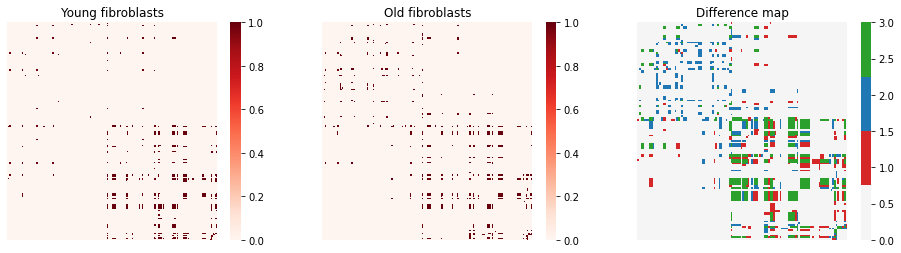

In [15]:
diff.plot_binarized_maps(young_HIF1A,old_HIF1A)
plt.savefig(fig_dir + 'binarized_hic_HIF1A.png')

## c) MRE11A

In [16]:
young_MRE11A = pd.read_csv(hic_dir+'processed_hic_data_IMR90/binarized_maps/MRE11A_subset.csv', index_col = 0)
old_MRE11A = pd.read_csv(hic_dir+'processed_hic_data_old_fibroblasts/binarized_maps/MRE11A_subset.csv', index_col = 0)

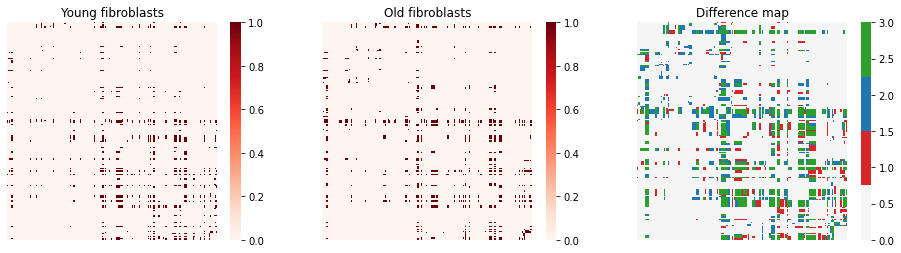

In [17]:
diff.plot_binarized_maps(young_MRE11A,old_MRE11A)
plt.savefig(fig_dir + 'binarized_hic_MRE11A.png')

# 3.) Clustering of the difference matrices

## a) BACH2

<Figure size 432x288 with 0 Axes>

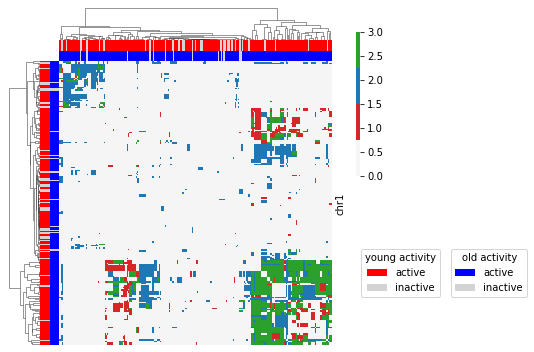

In [50]:
# Differences between young and old
diff_map = young_BACH2 + 2 * old_BACH2
# Filter for loci that are contained in a submatrix in at least one of the celltypes
diff_map = diff_map.loc[(diff_map!=0).any(axis=1), (diff_map!=0).any(axis=1)]
# Filter for loci that are targeted by only one of the TFs
diff_map = diff_map.loc[diff_map.index.isin(BACH2_specific), diff_map.index.isin(BACH2_specific)]

diff.plot_clustered_diff_map(diff_map, 'BACH2', save_dir)

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


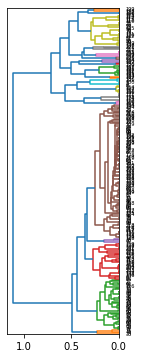

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [ 3 37 27  3 98  3  6  5  5  2  8  2  2  2  5  3 23  2  3]


In [32]:
# Hierarchical clustering
# create dendrogram
dend = linkage(diff_map, method='complete', metric=color_metric)
plt.figure(figsize = (2, 6))
dendrogram(dend, orientation = "left", color_threshold = 0.32)
plt.show()

clusters = fcluster(dend, 0.32, criterion = 'distance')
loci_clusters = pd.DataFrame({'locus': diff_map.index, 'cluster': clusters})
loci_clusters['chrom'] = loci_clusters['locus'].str.split('_').str[1]
# add target genes to loci-clustering
selected_loci = pd.read_csv(save_dir + 'TF_targets/BACH2_targets_loci.csv')
loci_clusters = loci_clusters.merge(selected_loci, how = "left", on = 'locus')
loci_clusters.to_csv(hic_dir + 'difference_maps/hierarchical_clusters_BACH2.csv', index = False)

unique, counts = np.unique(clusters, return_counts=True)
print(unique, counts)

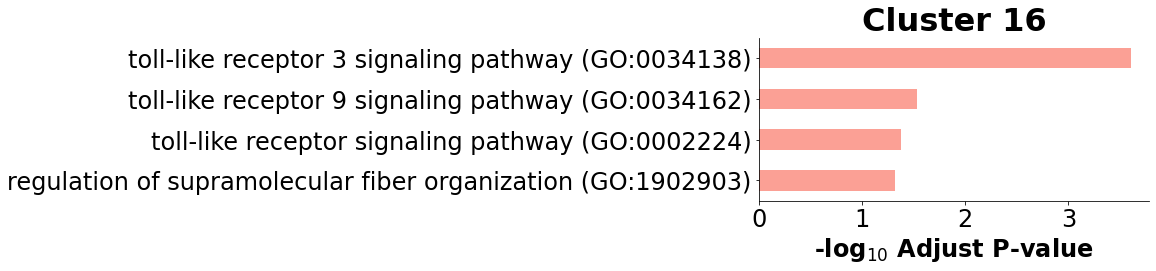

In [37]:
# Enrichment of the loci in one cluster
loci = loci_clusters.loc[loci_clusters['cluster'] == 17, 'locus']
selected_genes = selected_loci.loc[selected_loci['locus'].isin(loci), 'gene']

# GSEA on old genes
enr = gseapy.enrichr(gene_list= selected_genes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='',  format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 16',
        cutoff=0.05, top_term=5, figsize=(7, 3), color='salmon')

In [36]:
enr.results.head(5)

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,regulation of translation (GO:0006417),4/178,0.000432,0.127763,0,0,12.634738,97.893212,EIF4ENIF1;EIF5;LARP4;EIF3B,GO_Biological_Process_2021
1,response to endoplasmic reticulum stress (GO:0...,3/110,0.001379,0.128924,0,0,15.043950,99.083496,PPP1R15A;SCAMP5;BAX,GO_Biological_Process_2021
2,intrinsic apoptotic signaling pathway in respo...,2/29,0.001530,0.128924,0,0,38.855750,251.875506,PPP1R15A;BAX,GO_Biological_Process_2021
3,mitochondrion organization (GO:0007005),3/175,0.005130,0.128924,0,0,9.328096,49.183795,WDR81;BAX;PISD,GO_Biological_Process_2021
4,regulation of translational initiation (GO:000...,2/68,0.008174,0.128924,0,0,15.864434,76.256702,EIF5;EIF3B,GO_Biological_Process_2021


In [321]:
pd.Series([loc.split("_")[1] for loc in loci]).value_counts().rename_axis('chromosomes').reset_index(name='number of loci').transpose()

,0
chromosomes,17
number of loci,24


## b) HIF1A

<Figure size 432x288 with 0 Axes>

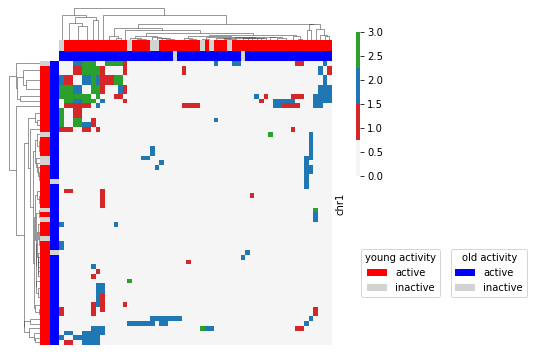

In [45]:
# Differences between young and old
diff_map = young_HIF1A + 2 * old_HIF1A
# Filter for loci that are contained in a submatrix in at least one of the celltypes
diff_map = diff_map.loc[(diff_map!=0).any(axis=1), (diff_map!=0).any(axis=1)]
# Filter for loci that are targeted by only one of the TFs
diff_map = diff_map.loc[diff_map.index.isin(HIF1A_specific), diff_map.index.isin(HIF1A_specific)]

diff.plot_clustered_diff_map(diff_map, 'HIF1A', save_dir)

## c) MRE11A

<Figure size 432x288 with 0 Axes>

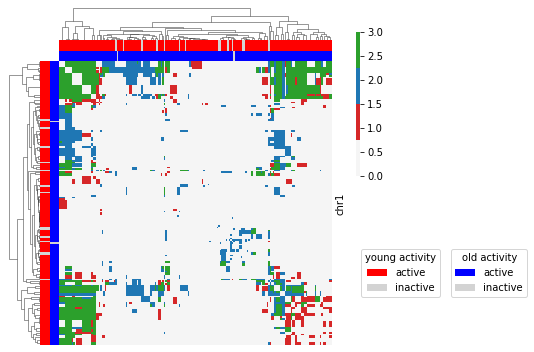

In [46]:
# Differences between young and old
diff_map = young_MRE11A + 2 * old_MRE11A
# Filter for loci that are contained in a submatrix in at least one of the celltypes
diff_map = diff_map.loc[(diff_map!=0).any(axis=1), (diff_map!=0).any(axis=1)]
# Filter for loci that are targeted by only one of the TFs
diff_map = diff_map.loc[diff_map.index.isin(MRE11A_specific), diff_map.index.isin(MRE11A_specific)]

diff.plot_clustered_diff_map(diff_map, 'MRE11A', save_dir)